In [1]:
from wrapped.utils import to_vis
import rasterio
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from pathlib import Path
import sys
sys.path.append('./satclip')
from satclip.load import get_satclip
from huggingface_hub import hf_hub_download
import torch
from sklearn.metrics.pairwise import cosine_similarity
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from math import radians, sin, cos, acos
import pandas as pd

D:\PyCharm 2024.2.1\Projects\pythonProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "./gen_results/val_all.pt"
data = torch.load(path, map_location="cpu")  # keep it on CPU for inspection

print(type(data))
print(data.keys())    # should show dict_keys(['clean', 'cloudy', 'pred'])

clean  = data["clean"]
cloudy = data["cloudy"]
pred   = data["pred"]

print("clean:",  clean.shape,  clean.dtype)
print("cloudy:", cloudy.shape, cloudy.dtype)
print("pred:",   pred.shape,   pred.dtype)

<class 'dict'>
dict_keys(['cloudy', 'clean', 'pred'])
clean: torch.Size([2050, 4, 128, 128]) torch.float32
cloudy: torch.Size([2050, 4, 128, 128]) torch.float32
pred: torch.Size([2050, 4, 128, 128]) torch.float32


In [3]:
print(clean.mean(), clean.std())

tensor(-0.4655) tensor(0.3340)


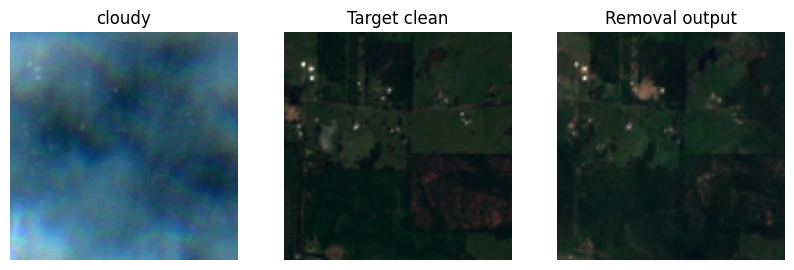

In [53]:
import wrapped.utils as utils
import importlib
importlib.reload(utils)
from wrapped.utils import visualize, to_vis, inspect_one

def visualize_from_pt(clean, cloudy, pred, idx=0):
    cloudy_vis = to_vis(cloudy[idx])#(4,H,W)->(H,W,3)
    clean_vis =to_vis(clean[idx])
    pred_vis= to_vis(pred[idx])
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.title("cloudy")
    plt.imshow(cloudy_vis)
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.title("Target clean")
    plt.imshow(clean_vis)
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.title("Removal output")
    plt.imshow(pred_vis)
    plt.axis("off")

idx = 500
visualize_from_pt(clean, cloudy, pred, idx=idx)




In [33]:

device = "cuda" if torch.cuda.is_available() else "cpu"

model = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ResNet50-L40", "satclip-resnet50-l40.ckpt"),
    return_all=True,
    device=device,
)

# ---------------------------------------------------------------------
# 1) Grab original 13-channel conv1 (we will NOT modify its weights)
# ---------------------------------------------------------------------
backbone = model.visual
old_conv = backbone.conv1
print("original conv1:", old_conv)   # Conv2d(13, ..., kernel_size=7, ...)

# ---------------------------------------------------------------------
# 2) Define 4 -> 13 spectral adapter (1x1 conv)
# ---------------------------------------------------------------------
class SpectralAdapter(nn.Module):
    """
    Maps 4-band input -> 13 pseudo-bands expected by SatCLIP.
    Initialized as: first 4 channels = identity, others = 0.
    """
    def __init__(self, in_ch=4, out_ch=13):
        super().__init__()
        self.proj = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=True)

        with torch.no_grad():
            # zero all weights/bias
            self.proj.weight.zero_()
            self.proj.bias.zero_()
            # make first min(in_ch, out_ch) channels identity-like
            k = min(in_ch, out_ch)
            for c in range(k):
                self.proj.weight[c, c, 0, 0] = 1.0

    def forward(self, x):
        # x: (B, 4, H, W)
        return self.proj(x)   # -> (B, 13, H, W)

# create adapter on same device / dtype as old_conv
adapter = SpectralAdapter(in_ch=4, out_ch=old_conv.in_channels).to(old_conv.weight.device)

# ---------------------------------------------------------------------
# 3) Freeze original conv1 (optional but recommended initially)
# ---------------------------------------------------------------------
for p in old_conv.parameters():
    p.requires_grad = False

# ---------------------------------------------------------------------
# 4) Replace conv1 with adapter + original conv1
# ---------------------------------------------------------------------
backbone.conv1 = nn.Sequential(adapter, old_conv)

model.to(device)
model.eval()

print("new conv1:", backbone.conv1)

using pretrained moco resnet50
original conv1: Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
new conv1: Sequential(
  (0): SpectralAdapter(
    (proj): Conv2d(4, 13, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
)


In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ResNet50-L40", "satclip-resnet50-l40.ckpt"),
    return_all=True,
    device=device,
)

backbone = model.visual
old_conv = backbone.conv1
print("original conv1:", old_conv)  # Conv2d(13, ..., kernel_size=7, ...)

# We assume input 4 channels are [B2, B3, B4, B8]  (Blue, Green, Red, NIR)
IDX_B2 = 2
IDX_B3 = 1
IDX_B4 = 0
IDX_B8 = 3

class SpectralAdapter(nn.Module):
    def __init__(self, in_ch=4, out_ch=13):
        super().__init__()
        self.proj = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=True)

        with torch.no_grad():
            self.proj.weight.zero_()
            self.proj.bias.zero_()

            W = self.proj.weight  # (13,4,1,1)

            # --- Visible / VNIR bands ---
            # B1 (443 nm) ~ "ultra blue": closest to B2
            W[0, IDX_B2, 0, 0] = 1.0

            # B2 (490 nm) : Blue
            W[1, IDX_B2, 0, 0] = 1.0

            # B3 (560 nm) : Green
            W[2, IDX_B3, 0, 0] = 1.0

            # B4 (665 nm) : Red
            W[3, IDX_B4, 0, 0] = 1.0

            # B5 (705 nm) between Red and NIR
            W[4, IDX_B4, 0, 0] = 0.7
            W[4, IDX_B8, 0, 0] = 0.3

            # B6 (740 nm) mid Red–NIR
            W[5, IDX_B4, 0, 0] = 0.5
            W[5, IDX_B8, 0, 0] = 0.5

            # B7 (783 nm) closer to NIR
            W[6, IDX_B4, 0, 0] = 0.3
            W[6, IDX_B8, 0, 0] = 0.7

            # B8 (842 nm) NIR
            W[7, IDX_B8, 0, 0] = 1.0

            # B8a (865 nm) NIR just a bit longer – copy NIR
            W[8, IDX_B8, 0, 0] = 1.0

            # B9 (940 nm) water-vapor band – approximate by slightly scaled NIR
            W[9, IDX_B8, 0, 0] = 0.8

            # --- SWIR bands (no direct info; use coarse NIR proxies) ---
            # B10 (1375 nm)
            W[10, IDX_B8, 0, 0] = 0.6

            # B11 (1610 nm)
            W[11, IDX_B8, 0, 0] = 0.6

            # B12 (2190 nm)
            W[12, IDX_B8, 0, 0] = 0.5

    def forward(self, x):
        return self.proj(x)  # (B,13,H,W)

# adapter on same device
adapter = SpectralAdapter(in_ch=4, out_ch=old_conv.in_channels).to(old_conv.weight.device)

# Freeze original 13-channel conv1 for now
for p in old_conv.parameters():
    p.requires_grad = False

# Replace conv1 with adapter + original conv1
backbone.conv1 = nn.Sequential(adapter, old_conv)

model.to(device)
model.eval()

print("new conv1:", backbone.conv1)

using pretrained moco resnet50
original conv1: Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
new conv1: Sequential(
  (0): SpectralAdapter(
    (proj): Conv2d(4, 13, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
)


In [35]:
def generate_control_locations(n):
    """
    Generates n regularly distributed locations on the planet
    :param n: Number of locations to generate
    :return: longitudes, latitudes of generated locations
    """
    import math
    n = n // 2
    # golden ratio
    phi = (1 + math.sqrt(5)) / 2

    lats, lons = [], []

    for i in np.arange(-n, n):
        lat = np.arcsin( (2*i) / (2*n + 1) ) * 180 / np.pi
        lon = (i % phi) * (360 / phi)

        if lon < -180:
            lon += 360
        if lon > 180:
            lon -= 360

        lons.append(lon)
        lats.append(lat)

    return np.stack(lons), np.stack(lats)

def arc_distance(lon1, lat1, lon2, lat2):
    """
    Calculates the great-circle distance between two points on Earth.
    :param lat1: Latitude of location 1 (in degrees)
    :param lon1: Longitude of location 1 (in degrees)
    :param lat2: Latitude of location 2 (in degrees)
    :param lon2: Longitude of location 2 (in degrees)
    :return: Distance in kilometers
    """
    mlat = radians(lat1)
    mlon = radians(lon1)
    plat = radians(lat2)
    plon = radians(lon2)

    dist = 6371.01 * acos(sin(mlat) * sin(plat) + cos(mlat) * cos(plat) * cos(mlon - plon))
    return dist

#Generate control locations
control_lons, control_lats = generate_control_locations(100000)
locs = torch.tensor(np.stack([control_lons, control_lats], axis=1)).to(device)
#Get location embeddings of control locations
with torch.no_grad():
  control_embs = model.encode_location(locs)

In [54]:
u = clean[idx]
x = cloudy[idx]
y = pred[idx]

In [55]:
# on truth
img_emb_u = model.visual(u.unsqueeze(0).to(device))
#Find row in control_embs that is closest to loc_emb by cosine similarity
cosine_sim_u = cosine_similarity(img_emb_u.cpu().detach().numpy(), control_embs.cpu().detach().numpy())
#Get index of control location corresponding to embedding with highest cosine similarity to image embedding
closest_u = np.argmax(cosine_sim_u)
print(control_lons[closest_u], control_lats[closest_u])

-93.92303947855606 36.59351743269001


In [56]:
# on cloudy
img_emb_x = model.visual(x.unsqueeze(0).to(device))
#Find row in control_embs that is closest to loc_emb by cosine similarity
cosine_sim_x = cosine_similarity(img_emb_x.cpu().detach().numpy(), control_embs.cpu().detach().numpy())
#Get index of control location corresponding to embedding with highest cosine similarity to image embedding
closest_x = np.argmax(cosine_sim_x)
print(control_lons[closest_x], control_lats[closest_x])

100.24825670367878 2.9164393427400843


In [57]:
# on pred
img_emb_y = model.visual(y.unsqueeze(0).to(device))
#Find row in control_embs that is closest to loc_emb by cosine similarity
cosine_sim_y = cosine_similarity(img_emb_y.cpu().detach().numpy(), control_embs.cpu().detach().numpy())
#Get index of control location corresponding to embedding with highest cosine similarity to image embedding
closest_y = np.argmax(cosine_sim_y)
print(control_lons[closest_y], control_lats[closest_y])

25.305667302277183 -50.09706825029283


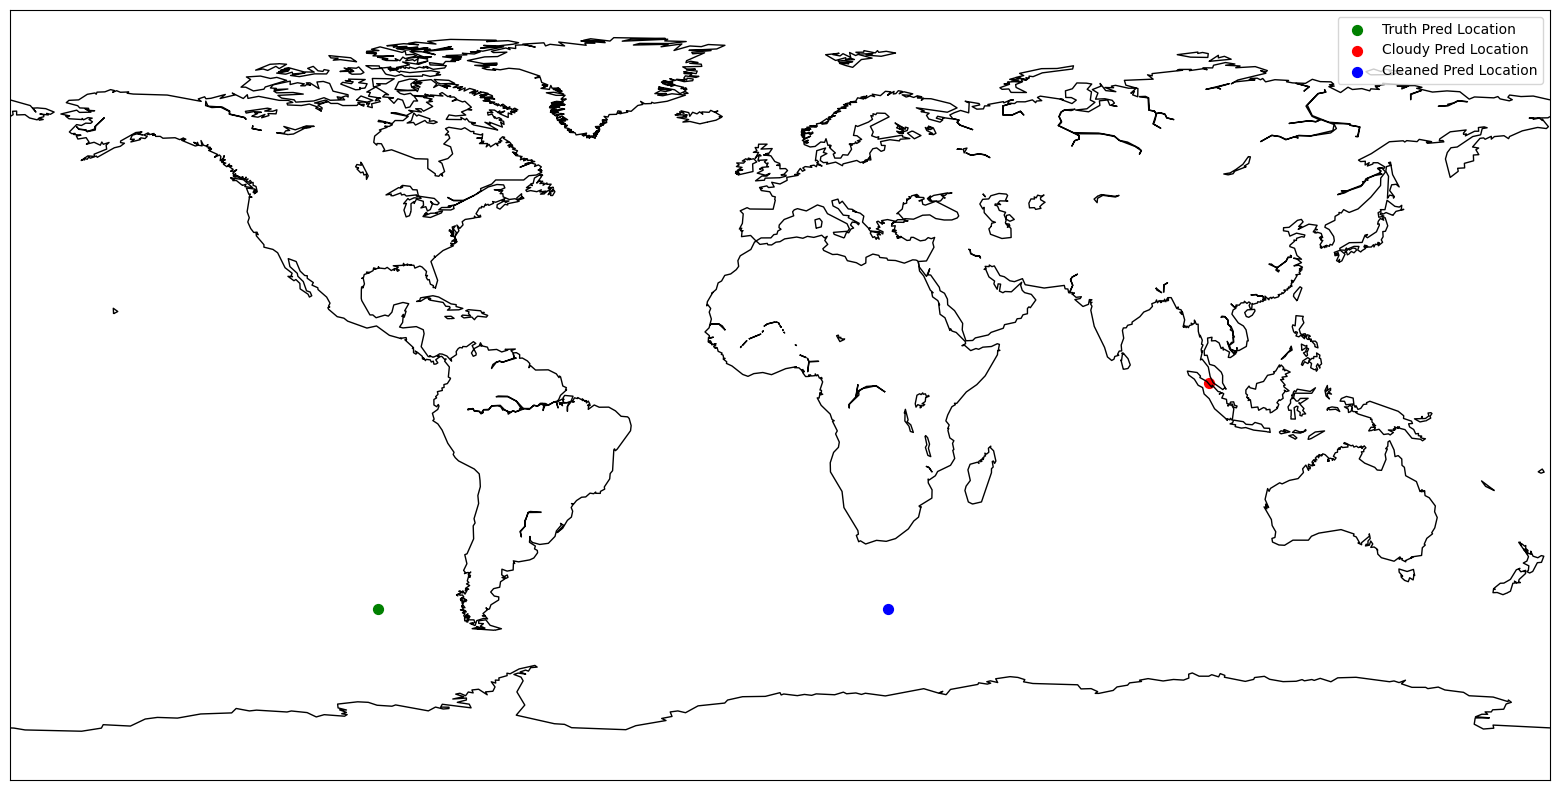

In [58]:
#Plot true and predicted locations
fig, ax = plt.subplots(1,1, figsize=(20, 10))

m = Basemap(projection='cyl', resolution='c', ax=ax)
m.drawcoastlines()
ax.scatter(control_lons[closest_u], control_lats[closest_y], s=50, c="green", label="Truth Pred Location")
ax.scatter(control_lons[closest_x], control_lats[closest_x], s=50, c="red", label="Cloudy Pred Location")
ax.scatter(control_lons[closest_y], control_lats[closest_y], s=50, c="blue", label="Cleaned Pred Location")
ax.legend()